In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
''' 
Define style specifying text details to save manual plot editing
General Ref: https://matplotlib.org/3.3.2/tutorials/introductory/customizing.html
'''
sns.set_theme(style = 'darkgrid', 
              rc = {'figure.titlesize' : 22, 
                    'figure.titleweight' : 'bold',
                    'axes.titleweight' : 'bold',
                    'axes.titlesize' : 22, 
                    'axes.labelweight' : 'bold',
                    'axes.labelsize' : 18,
                    'xtick.labelsize' : 14,
                    'ytick.labelsize' : 14
                   }
             )

# Data Import

In [7]:
train = pd.read_csv('./data/train.csv', index_col='id')
test = pd.read_csv('./data/test.csv', index_col='id')

features = train.columns.drop('target')
target = train.loc[:,['target']]
train.drop(columns = ['target'], inplace = True)


ss = StandardScaler()

train_ss = train.copy()
train_ss = ss.fit_transform(train_ss)
train_ss = pd.DataFrame(train_ss, index = train.index, columns = features)
test_ss = test.copy()
test_ss = ss.transform(test_ss)
test_ss = pd.DataFrame(test_ss, index = test.index, columns = features)



poly = PolynomialFeatures(degree = 2, include_bias=False)
ss = StandardScaler()


train_poly = train.copy()
train_poly = poly.fit_transform(train_poly)
train_poly = ss.fit_transform(train_poly)
train_poly = pd.DataFrame(train_poly, index = train.index, columns = poly.get_feature_names(features))
train_poly.columns = train_poly.columns.str.replace(' ', '_')

test_poly = test.copy()
test_poly = poly.transform(test_poly)
test_poly = ss.transform(test_poly)
test_poly = pd.DataFrame(test_poly, index = test.index, columns = poly.get_feature_names(features))
test_poly.columns = test_poly.columns.str.replace(' ', '_')


# Smaller Datasets for time efficient experimenting
train_ss_sub = train_ss.sample(frac = 0.25, axis = 0, random_state = 42)
train_ss_sub = train_ss_sub.sort_index()
train_poly_sub = train_poly.loc[train_poly.index.isin(train_ss_sub.index),:]
train_poly_sub = train_poly_sub.sort_index()
target_sub = target.loc[target.index.isin(train_ss_sub.index), :]
target_sub = target_sub.sort_index()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(train_ss_sub,
                                                    target_sub,
                                                    test_size = 0.4,
                                                    random_state = 42
                                                   )
X_train_poly, X_test_poly, y_train, y_test = train_test_split(train_poly_sub,
                                                    target_sub,
                                                    test_size = 0.4,
                                                    random_state = 42
                                                   )

# Motivation

Initial exploratory analysis and visualization revealed the target variable displays a multi-peak distribution. Specifically, we found two peaks which have some visual similarity to the overlap of two bell curves as demonstrated below.

In initial baseline modeling, linear models including the provided and engineered features barely outperformed a naive average prediction. If we can correctly identify which of the two apparent curves an observation belongs to in the target space, we can significantly improve predictive accuracy.



''

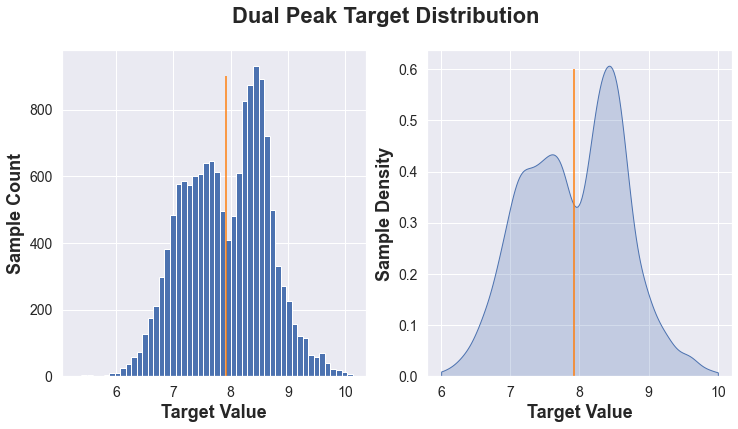

In [20]:
target_vis = target.sample(frac = 0.05, axis = 0, random_state = 42)
target_mean = target_vis.mean()

plt.figure(figsize=(12,6))
ax1 = plt.subplot(1, 2, 1)
plt.hist(target_vis['target'], bins = 50)
plt.xlabel('Target Value')
plt.ylabel('Sample Count')
plt.vlines(x = target_mean, ymin = 0, ymax = 900, color = 'tab:orange')

ax2 = plt.subplot(1, 2, 2)
sns.kdeplot(target_vis['target'], shade = True, clip = [6, 10])
plt.ylabel('Sample Density')
plt.xlabel('Target Value')
plt.vlines(x = target_mean, ymin = 0, ymax = 0.6, color = 'tab:orange')


plt.suptitle('Dual Peak Target Distribution')
;

''

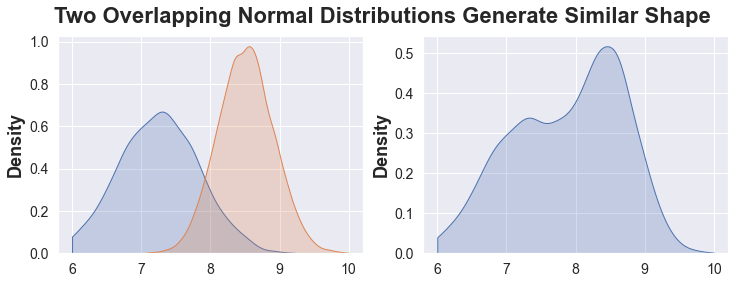

In [17]:
norm1 = np.random.normal(7.25, 0.6, 10000)
norm2 = np.random.normal(8.5, 0.4, 10000)
norm_all = np.concatenate((norm1, norm2))

f, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
sns.kdeplot(norm1, shade=True, clip = [6, 10], ax = axes[0])
sns.kdeplot(norm2, shade=True, clip = [6, 10], ax = axes[0])
sns.kdeplot(norm_all, shade=True, clip = [6, 10], ax = axes[1])
plt.suptitle('Two Overlapping Normal Distributions Generate Similar Shape')
;

''

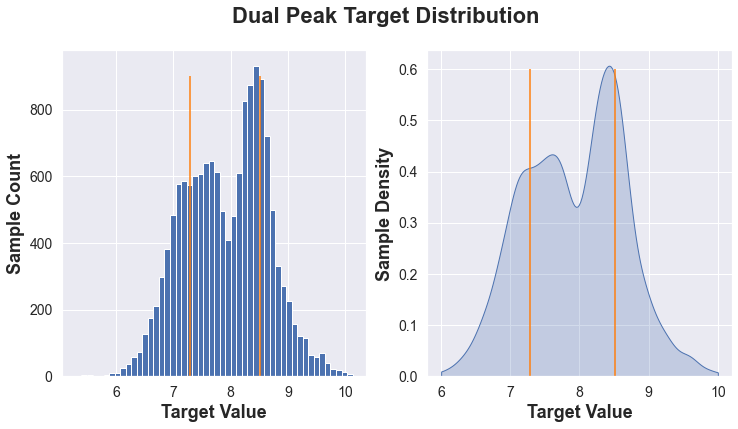

In [35]:
upper_mean = target_vis.loc[(target_vis > target_mean)['target'], 'target'].mean()
lower_mean = target_vis.loc[(target_vis < target_mean)['target'], 'target'].mean()


plt.figure(figsize=(12,6))
ax1 = plt.subplot(1, 2, 1)
plt.hist(target_vis['target'], bins = 50)
plt.xlabel('Target Value')
plt.ylabel('Sample Count')
plt.vlines(x = upper_mean, ymin = 0, ymax = 900, color = 'tab:orange')
plt.vlines(x = lower_mean, ymin = 0, ymax = 900, color = 'tab:orange')


ax2 = plt.subplot(1, 2, 2)
sns.kdeplot(target_vis['target'], shade = True, clip = [6, 10])
plt.ylabel('Sample Density')
plt.xlabel('Target Value')
plt.vlines(x = upper_mean, ymin = 0, ymax = 0.6, color = 'tab:orange')
plt.vlines(x = lower_mean, ymin = 0, ymax = 0.6, color = 'tab:orange')



plt.suptitle('Dual Peak Target Distribution')
;

In [57]:
train_2mean = y_train.copy()
y_mean = y_train.mean()['target']
low_mean = y_train.loc[y_train['target'] < y_mean, :].mean()['target']
high_mean = y_train.loc[y_train['target'] >= y_mean, :].mean()['target']

train_2mean['groupmean'] = 0
train_2mean.loc[train_2mean['target'] < y_mean, 'submean'] = low_mean
train_2mean.loc[train_2mean['target'] >= y_mean, 'submean'] = high_mean

train_2mean_rmse = np.sqrt(mean_squared_error(train_2mean['submean'], y_train))


pred_2mean = np.full(y_test.shape[0], low_mean)
pred_2mean = pd.DataFrame(pred_2mean, index = y_test.index, columns = ['pred'])
pred_2mean.loc[y_test['target'] > y_mean, 'pred'] = high_mean

test_2mean_rmse = np.sqrt(mean_squared_error(pred_2mean['pred'], y_test))


print('Train RMSE: {:.4f}'.format(train_2mean_rmse))
print('Test RMSE: {:.4f}'.format(test_2mean_rmse))


Train RMSE: 0.3890
Test RMSE: 0.3905


The test RMSE score above reveals the maximum predictive performance if we had perfect information about which curve an observation came from. In practice, we will have to predict this with some error. Given the weak relationship between provided and engineered features and the target, these features are unlikely to perform very well in predicting which target clump an observation belongs too.

# Binary Target Group Prediction

In [59]:
ygroup_train = np.full(y_train.shape[0], 0)
ygroup_train = pd.DataFrame(ygroup_train, index = y_train.index, columns = ['ygroup'])
ygroup_train.loc[y_train['target'] > 8, 'ygroup'] = 1

ygroup_test = np.full(y_test.shape[0], 0)
ygroup_test = pd.DataFrame(ygroup_test, index = y_test.index, columns = ['ygroup'])
ygroup_test.loc[y_test['target'] > 8, 'ygroup'] = 1


### Logistic

In [96]:
logreg = LogisticRegression()
logreg.fit(X_train, ygroup_train['ygroup'])

yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)

print('Train Accuracy: {:.4f}'.format(accuracy_score(yhat_train, ygroup_train)))
print('Test Accuracy: {:.4f}'.format(accuracy_score(yhat_test, ygroup_test)))


Train Accuracy: 0.5383
Test Accuracy: 0.5422


In [101]:
logreg = LogisticRegression(max_iter = 500, solver = 'lbfgs')
logreg.fit(X_train_poly, ygroup_train['ygroup'])

yhat_train = logreg.predict(X_train_poly)
yhat_test = logreg.predict(X_test_poly)

print('Train Accuracy: {:.4f}'.format(accuracy_score(yhat_train, ygroup_train)))
print('Test Accuracy: {:.4f}'.format(accuracy_score(yhat_test, ygroup_test)))


Train Accuracy: 0.5649
Test Accuracy: 0.5619


In [179]:
all_mean = y_train.mean()['target']
upper_mean = y_train.loc[(y_train > 8)['target'], 'target'].mean()
lower_mean = y_train.loc[(y_train < 8)['target'], 'target'].mean()


prob_class = logreg.predict_proba(X_train_poly)
prob_class = pd.DataFrame(prob_class, columns = ['p_0', 'p_1'])


prob_scale = prob_class - 0.5
prob_scale['p_0'] = prob_scale['p_0'].apply(lambda x: max(x, 0))
prob_scale['p_0'] = prob_scale['p_0']/max(prob_scale['p_0'])
prob_scale['p_1'] = prob_scale['p_1'].apply(lambda x: max(x, 0))
prob_scale['p_1'] = prob_scale['p_1']/max(prob_scale['p_1'])


y_weighted_mean = np.full(len(y_train), all_mean)
y_weighted_mean = y_weighted_mean + (upper_mean - all_mean)*prob_scale['p_1']
y_weighted_mean = y_weighted_mean + (lower_mean - all_mean)*prob_scale['p_0']
y_weighted_mean = pd.DataFrame(y_weighted_mean, columns = ['pred'])
y_weighted_mean.index = y_train.index

print('Train RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_weighted_mean, y_train))))


Train RMSE: 0.7188


In [181]:
prob_class = logreg.predict_proba(X_test_poly)
prob_class = pd.DataFrame(prob_class, columns = ['p_0', 'p_1'])


prob_scale = prob_class - 0.5
prob_scale['p_0'] = prob_scale['p_0'].apply(lambda x: max(x, 0))
prob_scale['p_0'] = prob_scale['p_0']/max(prob_scale['p_0'])
prob_scale['p_1'] = prob_scale['p_1'].apply(lambda x: max(x, 0))
prob_scale['p_1'] = prob_scale['p_1']/max(prob_scale['p_1'])


y_weighted_mean = np.full(len(y_test), all_mean)
y_weighted_mean = y_weighted_mean + (upper_mean - all_mean)*prob_scale['p_1']
y_weighted_mean = y_weighted_mean + (lower_mean - all_mean)*prob_scale['p_0']
y_weighted_mean = pd.DataFrame(y_weighted_mean, columns = ['pred'])
y_weighted_mean.index = y_test.index

print('Test RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_weighted_mean, y_test))))


test RMSE: 0.7199


### KNN Classifier

In [84]:
knn_params = {
    'n_neighbors': range(11, 362, 50),
    'metric': ['euclidean']
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), 
                                knn_params, 
                                scoring = 'f1', 
                                cv = 10, 
                                verbose = 1)
knn_gridsearcher.fit(X_train, ygroup_train['ygroup'])


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  8.3min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean'],
                         'n_neighbors': range(11, 362, 50)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [86]:
yhat_train = knn_gridsearcher.predict(X_train)
yhat_test = knn_gridsearcher.predict(X_test)

print('Train Accuracy: {:.4f}'.format(accuracy_score(yhat_train, ygroup_train)))
print('Test Accuracy: {:.4f}'.format(accuracy_score(yhat_test, ygroup_test)))


Train Accuracy: 0.5919
Test Accuracy: 0.5616


### Random Forest

In [94]:
rf_params = {
    'n_estimators': [50],
    'max_depth': [3, 5, 7, 9],
}
rf_gridsearcher = GridSearchCV(RandomForestClassifier(), 
                  param_grid = rf_params,
                  scoring = 'f1',
                  cv = 10)
rf_gridsearcher.fit(X_train_poly, ygroup_train['ygroup'])
print(rf_gridsearcher.best_score_)
rf_gridsearcher.best_params_

0.5033118687506134


{'max_depth': 9, 'n_estimators': 50}

In [95]:
yhat_train = rf_gridsearcher.predict(X_train_poly)
yhat_test = rf_gridsearcher.predict(X_test_poly)

print('Train Accuracy: {:.4f}'.format(accuracy_score(yhat_train, ygroup_train)))
print('Test Accuracy: {:.4f}'.format(accuracy_score(yhat_test, ygroup_test)))


Train Accuracy: 0.6721
Test Accuracy: 0.5748


## Expanded Data Import

In [5]:
train = pd.read_csv('./data/train_exp.csv', index_col='id')
test = pd.read_csv('./data/test_exp.csv', index_col='id')



X_train, X_test, y_train, y_test = train_test_split(train,
                                                    target,
                                                    test_size = 0.4,
                                                    random_state = 42
                                                   )


ygroup_train = np.full(y_train.shape[0], 0)
ygroup_train = pd.DataFrame(ygroup_train, index = y_train.index, columns = ['ygroup'])
ygroup_train.loc[y_train['target'] > 8, 'ygroup'] = 1

ygroup_test = np.full(y_test.shape[0], 0)
ygroup_test = pd.DataFrame(ygroup_test, index = y_test.index, columns = ['ygroup'])
ygroup_test.loc[y_test['target'] > 8, 'ygroup'] = 1


### Logistic

In [22]:
logreg = LogisticRegression(max_iter = 1000, solver = 'saga')
logreg.fit(X_train, ygroup_train['ygroup'])

yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)

print('Train Accuracy: {:.4f}'.format(accuracy_score(yhat_train, ygroup_train)))
print('Test Accuracy: {:.4f}'.format(accuracy_score(yhat_test, ygroup_test)))


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train Accuracy: 0.5668
Test Accuracy: 0.5659


In [23]:
all_mean = y_train.mean()['target']
upper_mean = y_train.loc[(y_train > 8)['target'], 'target'].mean()
lower_mean = y_train.loc[(y_train < 8)['target'], 'target'].mean()


prob_class = logreg.predict_proba(X_train)
prob_class = pd.DataFrame(prob_class, columns = ['p_0', 'p_1'])


prob_scale = prob_class - 0.5
prob_scale['p_0'] = prob_scale['p_0'].apply(lambda x: max(x, 0))
prob_scale['p_0'] = prob_scale['p_0']/max(prob_scale['p_0'])
prob_scale['p_1'] = prob_scale['p_1'].apply(lambda x: max(x, 0))
prob_scale['p_1'] = prob_scale['p_1']/max(prob_scale['p_1'])


y_weighted_mean = np.full(len(y_train), all_mean)
y_weighted_mean = y_weighted_mean + (upper_mean - all_mean)*prob_scale['p_1']
y_weighted_mean = y_weighted_mean + (lower_mean - all_mean)*prob_scale['p_0']
y_weighted_mean = pd.DataFrame(y_weighted_mean, columns = ['pred'])
y_weighted_mean.index = y_train.index

print('Train RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_weighted_mean, y_train))))


Train RMSE: 0.7224


In [24]:
prob_class = logreg.predict_proba(X_test)
prob_class = pd.DataFrame(prob_class, columns = ['p_0', 'p_1'])


prob_scale = prob_class - 0.5
prob_scale['p_0'] = prob_scale['p_0'].apply(lambda x: max(x, 0))
prob_scale['p_0'] = prob_scale['p_0']/max(prob_scale['p_0'])
prob_scale['p_1'] = prob_scale['p_1'].apply(lambda x: max(x, 0))
prob_scale['p_1'] = prob_scale['p_1']/max(prob_scale['p_1'])


y_weighted_mean = np.full(len(y_test), all_mean)
y_weighted_mean = y_weighted_mean + (upper_mean - all_mean)*prob_scale['p_1']
y_weighted_mean = y_weighted_mean + (lower_mean - all_mean)*prob_scale['p_0']
y_weighted_mean = pd.DataFrame(y_weighted_mean, columns = ['pred'])
y_weighted_mean.index = y_test.index

print('Test RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_weighted_mean, y_test))))


Test RMSE: 0.7202


### Random Forest

In [ ]:
rf_params = {
    'n_estimators': [50],
    'max_depth': [3, 5, 7, 9],
}
rf_gridsearcher = GridSearchCV(RandomForestClassifier(), 
                  param_grid = rf_params,
                  scoring = 'f1',
                  cv = 10)
rf_gridsearcher.fit(X_train_poly, ygroup_train['ygroup'])
print(rf_gridsearcher.best_score_)
rf_gridsearcher.best_params_

In [ ]:
yhat_train = rf_gridsearcher.predict(X_train)
yhat_test = rf_gridsearcher.predict(X_test)

print('Train Accuracy: {:.4f}'.format(accuracy_score(yhat_train, ygroup_train)))
print('Test Accuracy: {:.4f}'.format(accuracy_score(yhat_test, ygroup_test)))
